In [37]:
from keras.layers import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque
import sys

In [2]:
def load(name):
    # Loads the videos and converts the labels into one-hot encoding for Keras
    X = np.load(name + ".npy")
    y = np.load(name + "-labels.npy")
    y_one_hot_encoded = np.zeros([y.shape[0], np.unique(y).size])
    y_one_hot_encoded[range(y.shape[0]), y] = 1
    return X, y_one_hot_encoded

In [50]:
epochs = 10
batch_size = 64
learning_rate = 1e-5

# Loads the preprocessed datasets
print("Dataset loading..", end = " ")
X_train, y_train = load("training")
X_val, y_val = load("validation")
X_test, y_test = load("test")
print("Dataset loaded!")

Dataset loading.. Dataset loaded!


In [51]:
X_train = X_train.transpose(0,1,3,4,2)
X_val = X_val.transpose(0,1,3,4,2)
X_test = X_test.transpose(0,1,3,4,2)

In [54]:
def lrcn():
        """Build a CNN into RNN.
        Starting version from:
            https://github.com/udacity/self-driving-car/blob/master/
                steering-models/community-models/chauffeur/models.py
        Heavily influenced by VGG-16:
            https://arxiv.org/abs/1409.1556
        Also known as an LRCN:
            https://arxiv.org/pdf/1411.4389.pdf
        """
        def add_default_block(model, kernel_filters, init, reg_lambda):

            # conv
            model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                                             kernel_initializer=init)))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(Activation('relu')))
            # conv
            model.add(TimeDistributed(Conv2D(kernel_filters, (3, 3), padding='same',
                                             kernel_initializer=init)))
            model.add(TimeDistributed(BatchNormalization()))
            model.add(TimeDistributed(Activation('relu')))
            # max pool
            model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

            return model

        initialiser = 'glorot_uniform'
        reg_lambda  = 0.001

        model = Sequential()

        # first (non-default) block
        model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), padding='same',
                                         kernel_initializer=initialiser),
                                  input_shape=(45, 24, 24, 3)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(Conv2D(64, (3,3), kernel_initializer=initialiser)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

        # 2nd-5th (default) blocks
        model = add_default_block(model, 64,  init=initialiser, reg_lambda=reg_lambda)
        model = add_default_block(model, 128, init=initialiser, reg_lambda=reg_lambda)
        #model = add_default_block(model, 256, init=initialiser, reg_lambda=reg_lambda)
        #model = add_default_block(model, 512, init=initialiser, reg_lambda=reg_lambda)

        # LSTM output head
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(256, return_sequences=False, dropout=0.2))
        model.add(Dense(128,activation = 'relu'))
        model.add(Dense(y_train.shape[1], activation='softmax'))

        return model


In [55]:
model = lrcn()

In [35]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning_rate), metrics=["accuracy"])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_124 (TimeDi (None, 45, 12, 12, 32)    896       
_________________________________________________________________
time_distributed_125 (TimeDi (None, 45, 12, 12, 32)    128       
_________________________________________________________________
time_distributed_126 (TimeDi (None, 45, 12, 12, 32)    0         
_________________________________________________________________
time_distributed_127 (TimeDi (None, 45, 10, 10, 32)    9248      
_________________________________________________________________
time_distributed_128 (TimeDi (None, 45, 10, 10, 32)    128       
_________________________________________________________________
time_distributed_129 (TimeDi (None, 45, 10, 10, 32)    0         
_________________________________________________________________
time_distributed_130 (TimeDi (None, 45, 5, 5, 32)     

In [40]:
# settings for reducing the learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 0.0001, verbose = 1)

# Training the model on the training set, with early stopping using the validation set
callbacks = [EarlyStopping(patience = 7), reduce_lr]

In [41]:
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = (X_val, y_val), callbacks = callbacks)

Epoch 1/10
120/120 [==============================] - 1235s 10s/step - loss: 2.3313 - accuracy: 0.2835 - val_loss: 2.3668 - val_accuracy: 0.2833
Epoch 2/10
120/120 [==============================] - 330s 3s/step - loss: 1.9280 - accuracy: 0.4340 - val_loss: 2.1516 - val_accuracy: 0.2933
Epoch 3/10
120/120 [==============================] - 313s 3s/step - loss: 1.6739 - accuracy: 0.4725 - val_loss: 1.9362 - val_accuracy: 0.4080
Epoch 4/10
120/120 [==============================] - 312s 3s/step - loss: 1.5225 - accuracy: 0.5141 - val_loss: 1.6401 - val_accuracy: 0.4980
Epoch 5/10
120/120 [==============================] - 340s 3s/step - loss: 1.4077 - accuracy: 0.5493 - val_loss: 1.4177 - val_accuracy: 0.5533
Epoch 6/10
120/120 [==============================] - 319s 3s/step - loss: 1.3179 - accuracy: 0.5733 - val_loss: 1.2944 - val_accuracy: 0.5813
Epoch 7/10
120/120 [==============================] - 310s 3s/step - loss: 1.2481 - accuracy: 0.6032 - val_loss: 1.2250 - val_accuracy: 0.60

In [52]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
y_test = np.argmax(y_test,axis = 1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.40      0.45       123
           1       0.48      0.31      0.37        85
           2       0.00      0.00      0.00        10
           3       0.84      0.98      0.90       260
           4       0.65      0.54      0.59       147
           5       1.00      0.10      0.18        10
           6       0.00      0.00      0.00        30
           7       0.52      0.36      0.42        84
           8       0.53      0.17      0.26        52
           9       0.48      0.60      0.53       156
          10       0.68      0.87      0.76       424
          11       0.00      0.00      0.00         9
          12       0.59      0.57      0.58       110

    accuracy                           0.65      1500
   macro avg       0.48      0.38      0.39      1500
weighted avg       0.62      0.65      0.62      1500

[[ 49   5   0   1   0   0   0   1   0  14  48   0   5]
 [  2  26   0   1   8   

C:\Users\Saahil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


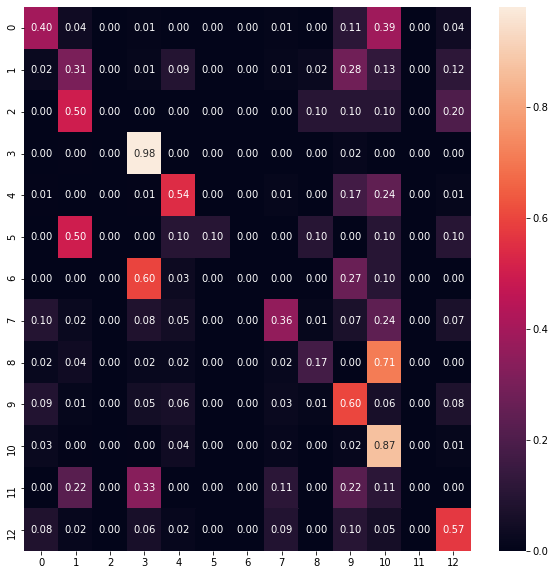

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f')